## Load libraries

In [1]:
import sys

import random
import logging
import time
from tqdm.notebook import tqdm
import pandas as pd
import pickle

sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from ocp import *
from costs import *
from ocp_utils import *
from env_creator import EnvCreator, generate_sdf_rep
from tensor_decomp import apply_tt
from visualization_utils import plot_traj_projections, plot_traj_and_obs_3d

import pybullet as p
import pybullet_data
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from regression import NN_Regressor, GPy_Regressor
from regression import rbf
import numpy.matlib

%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4, suppress=True)

## Load dataset

In [2]:
# exp_name = 'start_goal_fixed_100samples_5'
# exp_name = 'var_start_goal_1000samples_no_waypoint'
exp_name = 'var_start_goal_3000samples'
exp_name = 'var_start_goal_1000samples_no_waypoint'
exp_name = 'quad_mult_obs_var_start_goal_1000samples_2'
exp_name = 'quad_mult_obs_var_start_goal_1000samples_two_obstacles'
exp_name = 'quad_mult_obs_var_start_goal_1000samples_five_obstacles'
exp_name = 'quad_mult_obs_var_start_goal_1000samples_three_obstacles'

# exp_name = 'start_goal_fixed_300samples_1'
# exp_name = 'mult_obs_var_start_goal_1000samples_1'
# exp_name = 'mult_obs_var_start_goal_1000samples_teguh'
# exp_name = 'start_goal_fixed_300samples_quadcopter'
# exp_name = 'start_goal_fixed_300samples_1'
# exp_name = 'mult_obs_fixed_start_goal_1000samples'
# exp_name = 'mult_obs_100samples'
# exp_name = '2_obs_var_start_goal_1000samples'
# exp_name = '2_obs_100samples'
# exp_name = 'start_goal_fixed_300samples_1'
# exp_name = 'mult_obs_var_start_goal_500samples_1'

In [3]:
raw_data = load_data(exp_name)

The number of data points: 1660


#### Visualize data in pybullet

In [4]:
p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())

#### Check true data

In [5]:
i = np.random.randint(len(raw_data))

data = raw_data[i]
x0, x_target = data['x0'][:3], data['xT'][:3]
y_true =data['xs'][:,:3]
obstacles = data['obstacles']
quad_id, obj_id, init_id, target_id, border_id, obstacle_ids = init_pybullet_quadcopter(x0, x_target, obstacles)
col_status= eval_collision_geometric_general(obstacles, obj_id, y_true, margin=-0.01)
# print('According to current computation', np.max(col_status))

print(check_cost_general(data['xs'], x_target, obstacles, obj_id))

print('According to data',data['status'])

(False, False, True)
According to data False


In [6]:
plot_traj(y_true, obj_id, dt=0.02)

#### Run ddp to confirm the data

## Learn from the data

#### Filter the data

Only use the data when the trajectory:
- Has no collision
- Has 'True' as ddp status

In [7]:
status_ddp  = np.array([data['status'] for data in raw_data]) # Trajectories that have 'True' status from ddp
status_col  = np.array([data['collision_status'] for data in raw_data]) # Trajectories that have 'True' status based on collisionfinal_status = status_ddp
final_status = np.logical_and(status_ddp, np.logical_not(status_col))
status_ddp, status_col = status_ddp[final_status], status_col[final_status]

#### Extract the useful data

In [8]:
N_max = 5000

In [9]:
xs_set = np.array([data['xs'][:,:12] for data in raw_data])[final_status][:N_max]
init_positions = np.array([data['x0'][:12] for data in raw_data])[final_status][:N_max]
goal_positions = np.array([data['xT'][:12] for data in raw_data])[final_status][:N_max]
obs_set = np.array([data['obstacles'] for data in raw_data])[final_status][:N_max]
cost_set = np.array([data['cost'] for data in raw_data])[final_status][:N_max]
collision_set = np.array([data['collision_status'] for data in raw_data])[final_status][:N_max]

#### Generate sdf

In [10]:
from sdf import *

from tensor_decomp import apply_tt, orthogonalize, apply_parafac
def generate_tt_sdf(obstacles, tt_rank = 3):
    fs = []
    for obstacle in obstacles:
        pos = obstacle['pos']
        if obstacle['obs_type'] == p.GEOM_SPHERE:
            rad = obstacle['rad']
            f = sphere(rad).translate(pos)
        elif obstacle['obs_type'] == p.GEOM_CAPSULE:
            rad = obstacle['rad']
            length = obstacle['length']
            f = capsule([0,0,-length/2], [0,0,length/2], rad).translate(pos)
        elif obstacle['obs_type'] == p.GEOM_BOX:
            box_size = obstacle['halfExtents']
            f = box([box_size[0]*2,box_size[1]*2,box_size[2]*2] ).translate(pos)
        fs.append(f)
    f_t = fs[0]
    for f in fs[1:]:
        f_t = f_t | f
    points = f_t(env_builder.voxel_grid).reshape(40,40,40)
    tt_sdf_vol = apply_tt(points, rank=tt_rank) #.copy(order='C').astype(np.float32)
    tt_sdf_orth = orthogonalize(tt_sdf_vol)
    return points, tt_sdf_vol, tt_sdf_orth

#### Convert environment in SDF representation 

In [11]:
from sdf import *

In [12]:
voxel_res = 0.05 # voxel resolution in grid 
tt_rank = 3 # rank for tensor train decomposition -> should be as small as possible
grid_boundaries = \
 np.asarray([(-1,1),   # x
             (-1,1),   # y
             (-1,1)]   # z
            ) # 3x2, columns: (min, max) in world coordinates in meters

env_set = []
tt_env_set = []
full_data = []
env_builder = EnvCreator(grid_boundaries, voxel_res)
for i,obstacles in enumerate(obs_set):
    print(i)
    sdf_vol, tt_sdf_vol, tt_sdf_orth = generate_tt_sdf(obstacles, tt_rank)
    env_set.append(sdf_vol.flatten())
    tt_sdf_vol_array = np.concatenate([f.flatten() for f in tt_sdf_orth])
    tt_env_set.append(tt_sdf_vol_array.flatten()) # factors of the tensor train decomposition of the sdf tensor 

env_set = np.array(env_set)
tt_env_set = np.array(tt_env_set)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [13]:
# print('Shape of voxel grid: {}'.format(full_data[0]['sdf'].shape))
print('Shape of uncompressed environment data input: {}'.format(env_set.shape))
print('Shape of compressed environment data input: {}'.format(tt_env_set.shape))

Shape of uncompressed environment data input: (1102, 64000)
Shape of compressed environment data input: (1102, 600)


#### Construct the input output

Current system = point mass 

__input__:
- environment (tt-sdf representation) _or_ obstacle parameters

if dataset with varying start and goal positions additionally: 
- start_position of pointmass 
- target_position of pointmass

__output__:
- path trajectory

In [14]:
use_tt_rep = True # set this variable to use tt_representations as input variables 
start_goal_fixed = False # indicates whether to use start and goal position as additional input 

In [15]:
if use_tt_rep and start_goal_fixed: 
    x_inputs = tt_env_set
elif use_tt_rep and not start_goal_fixed: 
    x_inputs = np.concatenate([tt_env_set, init_positions, goal_positions], axis=1)
else: 
    x_inputs = np.concatenate([r_set[:,None], p_set], axis=1) # use obstacle parametrization instead 

N = len(x_inputs)
D_in = x_inputs.shape[1]
Dx = 3 #dimensions of point mass system (xyz)
T = 101 #number of time steps
print('Number of data instances: {}'.format(N))
print(x_inputs.shape)
x_outputs = xs_set.reshape(N,-1)

Number of data instances: 1102
(1102, 624)


#### Separate into train and test split

In [16]:
n_samples = len(x_inputs)
indices = np.arange(n_samples)

In [17]:
x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(x_inputs, x_outputs, indices, random_state=3, test_size=0.3)

In [18]:
print('\n',x_train.shape,'\n', y_train.shape,'\n', x_test.shape,'\n', y_test.shape)


 (771, 624) 
 (771, 1212) 
 (331, 624) 
 (331, 1212)


#### Use Dimensionality Reduction (optional)

In [19]:
use_pca = True
use_rbf = False

if use_pca:
    K = 25
    pca = PCA(n_components=K)
    y_train_pca = pca.fit_transform(y_train)
    y_test_pca = pca.transform(y_test)
    D_out = y_train_pca.shape[1]
elif use_rbf:
    rbf_transform = rbf(D=3, K = 8, offset = 20, width = 15, T = T)
    Phi = rbf_transform.create_RBF()

    plt.plot(Phi)
    plt.show()
    y_train_rbf = rbf_transform.transform(y_train.reshape(-1,T,Dx))
    y_test_rbf = rbf_transform.transform(y_test.reshape(-1,T,Dx))
    D_out = y_train_rbf.shape[1]
else:
    D_out = y_train.shape[1]

#### Save training data

In [20]:
data = dict()
if use_pca:
    data['pca'] = pca
elif use_rbf:
    data['rbf'] = rbf_transform
    
data['x_inputs'] = x_inputs
data['x_outputs'] = x_outputs
data['obstacles'] = obs_set
data['tt_env_set'] = tt_env_set
# data['env_set'] = env_set
data['tt_rank'] = tt_rank
data['voxel_res'] = voxel_res
data['use_pca'] = use_pca
data['use_rbf'] = use_rbf
np.save('training_data/data_'+ exp_name, data)

#### Load training data

### Test rbf (if necessary)

In [21]:
#Reconstructed y_train by inverse transform
if use_rbf: 
    y_train_rbf_rec = rbf_transform.inverse_transform(y_train_rbf)

#### Visualize the reconstructed traj

In [22]:
if use_rbf: 
    idx = np.random.randint(len(y_train_rbf_rec))
    y = y_train_rbf_rec[idx]
    y_true = y_train[idx].reshape(-1,Dx)

    fig, axs = plt.subplots(1,3)
    fig.set_size_inches(15,5)

    for i in range(3):
        axs[i].plot(y[:,i], '--b', label='Reconstructed')
        axs[i].plot(y_true[:,i], '-r', label='True')
        axs[i].legend()
    plt.show()

## Create & Train model

#### 0. Set predictor

In [23]:
# Set choice of predictor here: 
predictor_dct = {0: 'k-nn', 1: 'gpr', 2:'nn', 3: 'mdn'}
predictor = predictor_dct[1]

#### 1. Neural network

In [24]:
nn = Sequential([
    Dense(256, activation='relu', input_shape=(D_in,)),
    Dense(256, activation='relu'),
    Dense(D_out)
])

#nn.summary()

nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='mse') # set loss and optimizer 

In [25]:
batch_size = 16
if use_pca:
    history = nn.fit(x_train, y_train_pca,batch_size=batch_size, validation_split=0.2, epochs=300, callbacks=[tf.keras.callbacks.EarlyStopping(patience=30)])
elif use_rbf:
    history = nn.fit(x_train, y_train_rbf,batch_size=batch_size, validation_split=0.2, epochs=300, callbacks=[tf.keras.callbacks.EarlyStopping(patience=30)])
else:
    history = nn.fit(x_train, y_train,batch_size=batch_size, validation_split=0.2, epochs=300, callbacks=[tf.keras.callbacks.EarlyStopping(patience=30)])

Epoch 1/300
39/39 [==============================] - 0s 5ms/step - loss: 2.5414 - val_loss: 1.2644
Epoch 2/300
39/39 [==============================] - 0s 3ms/step - loss: 1.0878 - val_loss: 1.2081
Epoch 3/300
39/39 [==============================] - 0s 2ms/step - loss: 1.0567 - val_loss: 1.1937
Epoch 4/300
39/39 [==============================] - 0s 2ms/step - loss: 1.0475 - val_loss: 1.2089
Epoch 5/300
39/39 [==============================] - 0s 1ms/step - loss: 1.0343 - val_loss: 1.2009
Epoch 6/300
39/39 [==============================] - 0s 2ms/step - loss: 1.0350 - val_loss: 1.1988
Epoch 7/300
39/39 [==============================] - 0s 2ms/step - loss: 1.0175 - val_loss: 1.1975
Epoch 8/300
39/39 [==============================] - 0s 2ms/step - loss: 1.0101 - val_loss: 1.1908
Epoch 9/300
39/39 [==============================] - 0s 2ms/step - loss: 1.0028 - val_loss: 1.1969
Epoch 10/300
39/39 [==============================] - 0s 2ms/step - loss: 1.0088 - val_loss: 1.2000
Epoch 11/

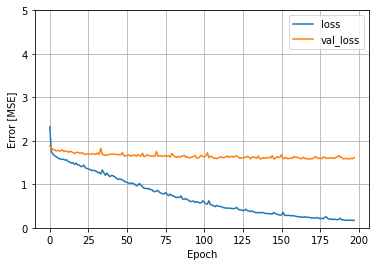

In [25]:
plot_loss(history, y_range=[0,5])

In [26]:
nn.save('model_data/nn_'+exp_name+'.h5')

#### 2. k-Nearest Neighbor (knn)

In [27]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(1)
if use_pca:
    knn.fit(x_train, y_train_pca)
elif use_rbf:
    knn.fit(x_train, y_train_rbf)
else:
    knn.fit(x_train, y_train)

#### 3. Gaussian Process Regressor (GPR)

#### 4 Mixture Density Network (MDN) 

In [28]:
import tensorflow_probability as tfp

In [29]:
tf.keras.backend.set_floatx('float64')

In [30]:
tfd = tfp.distributions
tfpl = tfp.layers

In [31]:
n_comps = 10
n_comp_params_size = tfpl.IndependentNormal.params_size(event_shape=(D_out,))

params_size = tfpl.MixtureSameFamily.params_size(num_components=n_comps, component_params_size=n_comp_params_size)

mdn = Sequential([
    Dense(256, activation='relu', input_shape=(D_in,), kernel_regularizer = tf.keras.regularizers.l2(1e-2)),
    Dense(256, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-2)),
    Dense(params_size),
    tfpl.MixtureSameFamily(n_comps, tfpl.IndependentNormal(event_shape=(D_out,)))
])

def loss(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [32]:
mdn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=loss)

In [33]:
batch_size = 16
if use_pca:
    history = mdn.fit(x_train, y_train_pca,batch_size=batch_size, validation_split=0.1, epochs=300, callbacks=[tf.keras.callbacks.EarlyStopping(patience=30)], verbose=1)
elif use_rbf:
    history = mdn.fit(x_train, y_train_rbf,batch_size=batch_size, validation_split=0.1, epochs=300, callbacks=[tf.keras.callbacks.EarlyStopping(patience=30)])
else:
    history = mdn.fit(x_train, y_train,batch_size=batch_size, validation_split=0.1, epochs=300, callbacks=[tf.keras.callbacks.EarlyStopping(patience=30)])

Epoch 1/300
44/44 [==============================] - 1s 10ms/step - loss: 55.9347 - val_loss: 36.4927
Epoch 2/300
44/44 [==============================] - 0s 4ms/step - loss: 31.9623 - val_loss: 25.8822
Epoch 3/300
44/44 [==============================] - 0s 4ms/step - loss: 24.4968 - val_loss: 19.5209
Epoch 4/300
44/44 [==============================] - 0s 4ms/step - loss: 20.1493 - val_loss: 17.6277
Epoch 5/300
44/44 [==============================] - 0s 4ms/step - loss: 18.2945 - val_loss: 16.0776
Epoch 6/300
44/44 [==============================] - 0s 4ms/step - loss: 16.8066 - val_loss: 15.7407
Epoch 7/300
44/44 [==============================] - 0s 4ms/step - loss: 15.8750 - val_loss: 14.3632
Epoch 8/300
44/44 [==============================] - 0s 4ms/step - loss: 14.5761 - val_loss: 13.8546
Epoch 9/300
44/44 [==============================] - 0s 4ms/step - loss: 13.2172 - val_loss: 13.6156
Epoch 10/300
44/44 [==============================] - 0s 5ms/step - loss: 13.1454 - val_lo

In [34]:
mdn.save_weights('model_data/mdn_'+exp_name)

## Evaluation 

In [35]:
# Predict
def predict(model, predictor, x, Dx=3, dim_red='pca', n_sample=1, take_mean = False): 
    if predictor == 'gpr':
        y_pred, y_cov = model.predict(x, False)
    elif predictor == 'nn':
        y_pred = model.predict(x)
    elif predictor == 'mdn': 
        if take_mean:
            y_pred = np.transpose(np.array(model(x).components_distribution.mean()), axes=(1,0,2))
        else:
            y_pred = np.array(model(x).sample(n_sample))
            
    elif predictor == 'knn':
        y_pred = model.predict(x)

    #Inverse transform, if using PCA or rbf
    if dim_red == 'pca':
        y_traj = pca.inverse_transform(y_pred)
    elif dim_red == 'rbf':
        y_traj = rbf_transform.inverse_transform(y_pred)
    elif dim_red == None:
        y_traj = np.array(y_pred)
    else: 
        raise NotImplementedError
    return y_traj, y_pred 

### Quantitative

In [37]:
model = knn # options = {gpr, nn, mdn, knn}
mode = 'knn'
dim_red = 'pca'

#### MSE (Mean Squared Error)

$\mathrm{MSE}=\frac{1}{n}\sum_{i=1}^n (\hat{y_i} - y_i)^2$

#### MSE, only for MDN

#### MSE for general model

#### Filter based on ddp cost

In [65]:
model = mdn
mode = 'mdn'

In [59]:
model = nn
mode = 'nn'

#### Evaluate the model

In [66]:
Dx = 12

In [111]:
errors = []
goal_errors = []
col_set = []
true_col_set = []
trajs = []
K = 10
for i in range(1):#len(x_test)): # iterate over all trajectories 
    print(i)
    x = x_test[i]
#     print(x)
    y_true = y_test[i].reshape(-1,Dx)    
    full_idx = test_idx[i]
    obstacles = obs_set[full_idx]
#     print(obstacles)
    x0, x_target = x[-24:-12], x[-12:]
    quad_id, obj_id, init_id, target_id, border_id, obstacle_ids = init_pybullet_quadcopter(x0, x_target, obstacles)
#     x0 = np.concatenate([x0, np.zeros(6)])
#     x_target = np.concatenate([x_target, np.zeros(6)])
    if mode == 'mdn':
        y_traj, _ = predict(model, mode, x[None,:], dim_red=dim_red, n_sample=K)
        y_traj = y_traj.reshape(K,T,Dx)
        y_traj, xs_init, us_init  = get_best_mdn_prediction_ddp2(y_traj, x, obstacles, general_obs=True, obj_id=obj_id, add_zeros_dim = 0)
#         y_traj = get_best_mdn_prediction_mse(y_traj, y_true.flatten())
    else:
        y_traj, _ = predict(model, mode, x[None,:], dim_red=dim_red)
        y_traj = y_traj.reshape(T,Dx)
        
    trajs.append(y_traj)
    residuals = np.square(np.subtract(y_traj, y_true))
    errors.append(np.mean(residuals))
    goal_errors.append(residuals[-1])
    
    #check collision
    col_status= eval_collision_geometric_general(obstacles, obj_id, y_traj, margin = -0.01)
    col_set.append(np.max(col_status))

    col_status= eval_collision_geometric_general(obstacles, obj_id, y_true)
    true_col_set.append(np.max(col_status))

0
1.9231736860577433


In [62]:
print(np.sum(col_set))

print(np.sum(true_col_set))

total_mse = np.mean(errors)
goal_mse = np.mean(goal_errors)

print('MSE: \n - total: {:.6f}\n - goal positions: {:.6f}'.format(total_mse, goal_mse))

250
0
MSE: 
 - total: 0.017166
 - goal positions: 0.002027


In [63]:
np.set_printoptions(precision=4, suppress=True)

In [64]:
col_percent = (1-np.sum(col_set)/len(col_set))
print('{0:.4f}'.format(total_mse))
print('{0:.4f}'.format(goal_mse))
print('{0:.4f}'.format(col_percent))


0.0172
0.0020
0.2447


In [58]:
col_percent = (1-np.sum(col_set)/len(col_set))
print('{0:.4f}'.format(total_mse))
print('{0:.4f}'.format(goal_mse))
print('{0:.4f}'.format(col_percent))


0.0413
0.0188
0.6737


In [49]:
col_percent = (1-np.sum(col_set)/len(col_set))
print('{0:.4f}'.format(total_mse))
print('{0:.4f}'.format(goal_mse))
print('{0:.4f}'.format(col_percent))


0.0446
0.0208
0.3625


In [58]:
col_percent = (1-np.sum(col_set)/len(col_set))
print('{0:.4f}'.format(total_mse))
print('{0:.4f}'.format(goal_mse))
print('{0:.4f}'.format(col_percent))


0.0530
0.0161
0.4810


In [119]:
col_percent = (1-np.sum(col_set)/len(col_set))
print('{0:.4f}'.format(total_mse))
print('{0:.4f}'.format(goal_mse))
print('{0:.4f}'.format(col_percent))


0.0533
0.0185
0.3571


In [125]:
col_percent = (1-np.sum(col_set)/len(col_set))
print('{0:.4f}'.format(total_mse))
print('{0:.4f}'.format(goal_mse))
print('{0:.4f}'.format(col_percent))


0.0348
0.0096
0.2643


#### Try MDN prediction

In [96]:
model = mdn
mode = 'mdn'

In [135]:
idx = np.random.randint(len(x_test))

In [136]:
x = x_test[idx]
y_true = y_test[idx]
full_idx = test_idx[idx]
obstacles = obs_set[full_idx]
x0, x_target = x[-6:-3], x[-3:]
obj_id, init_id, target_id, border_id, obstacle_ids = init_pybullet(x0, x_target, obstacles)


y_traj, _ = predict(model, mode, x[None,:], dim_red=dim_red, n_sample = K)
y_traj = y_traj.reshape(K,T,Dx)

In [140]:
lin_sys = create_double_integrator()

y_traj = get_best_mdn_prediction_ddp(y_traj, x, obstacles, general_obs=True, obj_id=obj_id, add_zeros_dim = 9, verbose = True)

xs_init, us_init = create_lqt_init_quad(lin_sys, y_traj, x0[:3], x_target[:3], T)

y_traj = xs_init[:,:3]

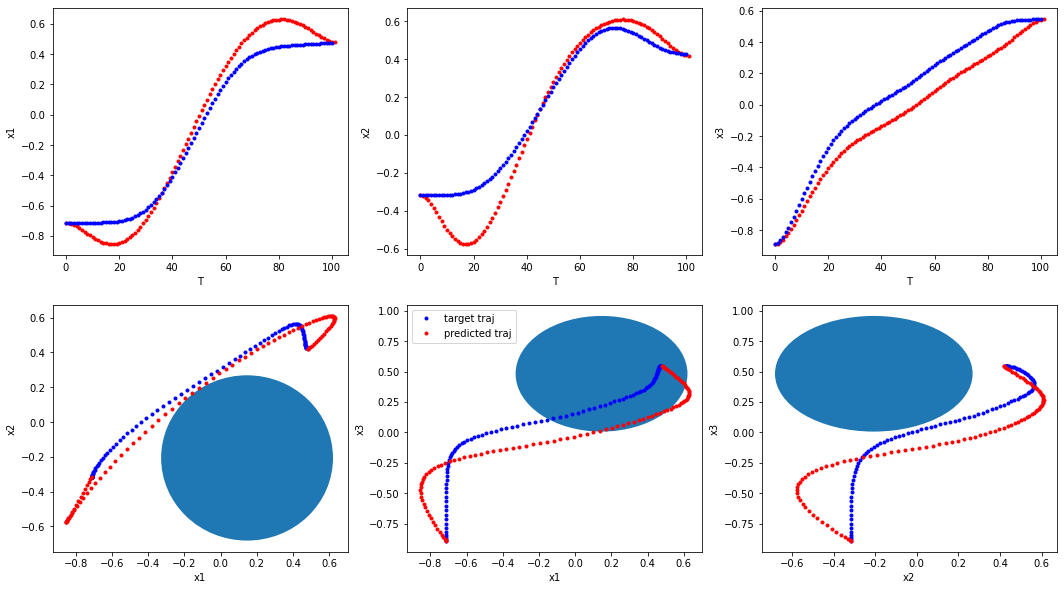

In [141]:
plot_traj_projections(y_true.reshape(-1,Dx), obstacles, y_traj)